In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

# Data Preparation

In [ ]:
class_name = 'Occupancy'

dataset_path="/content/drive/Shared drives/DM2/files/combined2.csv"
df = pd.read_csv(dataset_path)

del df['Hour']
del df['Date']

print (df)

       Day  TimeSlot  Weekend  ...        CO2  HumidityRatio  Occupancy
0        2         2        0  ...   5.235582      10.795786          1
1        2         2        0  ...   5.343291      10.831549          1
2        2         2        0  ...   5.432407      10.799950          1
3        2         2        0  ...   5.481292      10.709977          1
4        2         2        0  ...   5.522164      10.806016          1
...    ...       ...      ...  ...        ...            ...        ...
20555   18         1        0  ...  12.506386       8.476117          1
20556   18         1        0  ...  12.595342       8.548897          1
20557   18         1        0  ...  12.662660       8.576488          1
20558   18         1        0  ...  13.725319       8.756051          1
20559   18         1        0  ...  15.956424       8.929634          1

[20560 rows x 10 columns]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append('./')

In [ ]:
def prepare_dataset(df, class_name):
    df = remove_missing_values(df)
    numeric_columns = get_numeric_columns(df)
    rdf = df.copy(deep=True)
    df, feature_names, class_values = one_hot_encoding(df, class_name)
    real_feature_names = get_real_feature_names(rdf, numeric_columns, class_name)
    rdf = rdf[real_feature_names + (class_values if isinstance(class_name, list) else [class_name])]
    features_map = get_features_map(feature_names, real_feature_names)

    return df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map

def remove_missing_values(df):
    for column_name, nbr_missing in df.isna().sum().to_dict().items():
        if nbr_missing > 0:
            if column_name in df._get_numeric_data().columns:
                mean = df[column_name].mean()
                df[column_name].fillna(mean, inplace=True)
            else:
                mode = df[column_name].mode().values[0]
                df[column_name].fillna(mode, inplace=True)
    return df

def get_numeric_columns(df):
    numeric_columns = list(df._get_numeric_data().columns)
    return numeric_columns

def get_real_feature_names(rdf, numeric_columns, class_name):
    real_feature_names = [c for c in rdf.columns if c in numeric_columns and c != class_name]
    real_feature_names += [c for c in rdf.columns if c not in numeric_columns and c != class_name]
    return real_feature_names

def one_hot_encoding(df, class_name):
    dfX = pd.get_dummies(df[[c for c in df.columns if c != class_name]], prefix_sep='=')
    class_name_map = {v: k for k, v in enumerate(sorted(df[class_name].unique()))}
    dfY = df[class_name].map(class_name_map)
    df = pd.concat([dfX, dfY], axis=1)
    feature_names = list(dfX.columns)
    class_values = sorted(class_name_map)
    return df, feature_names, class_values

def get_features_map(feature_names, real_feature_names):
    features_map = defaultdict(dict)
    i = 0
    j = 0

    while i < len(feature_names) and j < len(real_feature_names):
        if feature_names[i] == real_feature_names[j]:
            features_map[j][feature_names[i]] = j
            i += 1
            j += 1
        elif feature_names[i].startswith(real_feature_names[j]):
            features_map[j][feature_names[i]] = j
            i += 1
        else:
            j += 1
    return features_map

In [ ]:
res = prepare_dataset(df, class_name)
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = res
df.head()

,Day,TimeSlot,Weekend,WorkingHour,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2,2,0,1,15.904468,8.698835,7.516689,5.235582,10.795786,1
1,2,2,0,1,15.957720,8.711492,7.452585,5.343291,10.831549,1
2,2,2,0,1,15.993220,8.669303,7.398537,5.432407,10.799950,1
3,2,2,0,1,15.971032,8.595474,6.654588,5.481292,10.709977,1
4,2,2,0,1,16.064222,8.648209,6.606039,5.522164,10.806016,1


# Data Partitioning

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [ ]:
attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

# Normalization

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# PERCEPTRON

In [ ]:
#!pip install tensorflow==1.14.0
!pip install Keras==2.3.0

from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers




     |████████████████████████████████| 378kB 2.9MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


# PERCEPTRON CON HIDDEN LAYER

## appunti



COMBINAZIONE: 
  ACTIVATION FUNCTION: TANH 
  OTTIMIZZATORE: ADAM CON LEARNING RATE 0.001


APPUNTI: CON TAHN SPESSO L'ACCURACY CALA DRASTICAMENTE (coverge in minimo locale ma la loss curve non indica un overfitting) MENTRE AGGIUNGENDO SIGMOID FUNCTION OTTENGO UN INCREMENTO DELL'ACCURACY E NON OVERFITTING

MODELLO PERCEPTRON SENZA STRATO INTERMEDIO FUNZIONANTE:
  1. OTTIMIZZATORE ADAM CON LEARNING RATE 0.001
  2. STRATO INTERMEDIO CON CINQUE NODI 
  3. FUNZIONE DI ATTIVAZIONE "SIGMOID"
  4. 500 EPOCHE E BATCH SIZE DI 500 

Questo modello converge sempre al minimo globale e non provoca overfitting nel modello, accuracy elevatissima.

MODELLO PERCEPTRON SENZA STRATO INTERMEDIO NON FUNZIONANTE:
  1. OTTIMIZZATORE SGD CON LEARNING RATE 1 E MOMENTUM 0.4
  2. STRATO INTERMEDIO CON TRENTA NODI 
  3. FUNZIONE DI ATTIVAZIONE "TANH"
  4. 500 EPOCHE E BATCH SIZE DI 1000 

Questo modello ha problemi di convergenza, in quanto l'accuracy cala drasticamente col passare delle epoche. Si riscontra inoltre un comportamento anomalo nella loss curve, dove la curva del validation segue un andamento totalmente sbilanciato da quello del test set. Implica overfitting o convergenze in un minimo locale.



## perceptron con hidden layer che non funge

In [ ]:
a = optimizers.SGD(learning_rate=1, momentum=0.4)
b = optimizers.adam(learning_rate=0.001)

def build_model2():
    
    n_feature = X_train.shape[1]

    model = Sequential()
    model.add(Dense(30, input_dim=n_feature, activation='tanh'))
    model.add(Dense(1, activation='tanh'))

    
    model.compile(loss='binary_crossentropy', optimizer=a, metrics=['accuracy'])
    return model


Train on 14392 samples, validate on 6168 samples
Epoch 1/500
14392/14392 [==============================] - 0s 21us/step - loss: 0.2534 - accuracy: 0.2599 - val_loss: 0.0480 - val_accuracy: 0.2369
Epoch 2/500
14392/14392 [==============================] - 0s 3us/step - loss: 0.0479 - accuracy: 0.2377 - val_loss: 0.0471 - val_accuracy: 0.2412
Epoch 3/500
14392/14392 [==============================] - 0s 3us/step - loss: 0.0449 - accuracy: 0.2476 - val_loss: 0.0459 - val_accuracy: 0.2511
Epoch 4/500
14392/14392 [==============================] - 0s 2us/step - loss: 0.0441 - accuracy: 0.2595 - val_loss: 0.0462 - val_accuracy: 0.2594
Epoch 5/500
14392/14392 [==============================] - 0s 3us/step - loss: 0.0440 - accuracy: 0.2591 - val_loss: 0.0435 - val_accuracy: 0.2597
Epoch 6/500
14392/14392 [==============================] - 0s 3us/step - loss: 0.0436 - accuracy: 0.2601 - val_loss: 0.0430 - val_accuracy: 0.2560
Epoch 7/500
14392/14392 [==============================] - 0s 3us/st

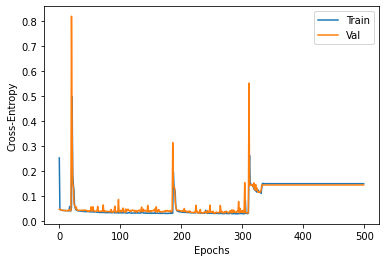

In [ ]:
model2 = build_model2()

history2 = model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=500, batch_size=1000).history

plt.plot(history2['loss'], label='Train')
plt.plot(history2['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

In [ ]:
# Test the model after training
test_results = model2.evaluate(X_test, y_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')

6168/6168 [==============================] - 0s 23us/step
Test results - Loss: 0.14508321209682046 - Accuracy: 0.23054474592208862%


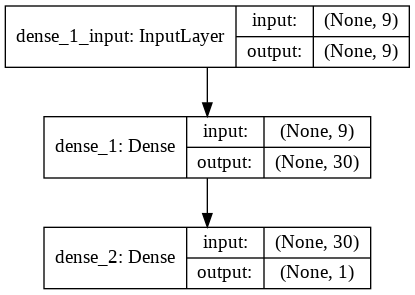

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model2, show_shapes=True, show_layer_names=True)

## perceptron con hidden layer che funge

In [ ]:
a = optimizers.SGD(learning_rate=0.001, momentum=0)
b = optimizers.adam(learning_rate=0.001)

def build_model():
    
    n_feature = X_train.shape[1]

    model = Sequential()
    model.add(Dense(5, input_dim=n_feature, activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid'))

    
    model.compile(loss='binary_crossentropy', optimizer=b, metrics=['accuracy'])
    return model


Train on 14392 samples, validate on 6168 samples
Epoch 1/500
14392/14392 [==============================] - 0s 10us/step - loss: 0.5476 - accuracy: 0.7689 - val_loss: 0.5309 - val_accuracy: 0.7688
Epoch 2/500
14392/14392 [==============================] - 0s 4us/step - loss: 0.5146 - accuracy: 0.7689 - val_loss: 0.4990 - val_accuracy: 0.7688
Epoch 3/500
14392/14392 [==============================] - 0s 5us/step - loss: 0.4836 - accuracy: 0.7689 - val_loss: 0.4688 - val_accuracy: 0.7690
Epoch 4/500
14392/14392 [==============================] - 0s 4us/step - loss: 0.4542 - accuracy: 0.7690 - val_loss: 0.4403 - val_accuracy: 0.7691
Epoch 5/500
14392/14392 [==============================] - 0s 4us/step - loss: 0.4265 - accuracy: 0.7690 - val_loss: 0.4135 - val_accuracy: 0.7695
Epoch 6/500
14392/14392 [==============================] - 0s 4us/step - loss: 0.4004 - accuracy: 0.7690 - val_loss: 0.3881 - val_accuracy: 0.7695
Epoch 7/500
14392/14392 [==============================] - 0s 4us/st

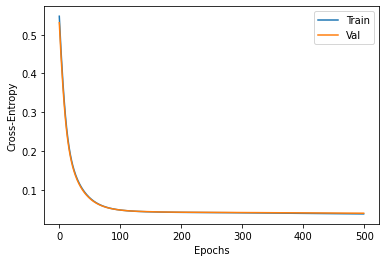

In [ ]:
model1 = build_model()

history3 = model1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=500, batch_size=500).history

plt.plot(history3['loss'], label='Train')
plt.plot(history3['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

## confronto

In [ ]:
test_loss_1, test_acc_1 = model1.evaluate(X_test, y_test)
test_loss_2, test_acc_2 = model2.evaluate(X_test, y_test)

print('Loss %f, Accuracy %f' % (test_loss_1, test_acc_1))
print('Loss %f, Accuracy %f' % (test_loss_2, test_acc_2))

6168/6168 [==============================] - 0s 19us/step
Loss 0.039509, Accuracy 0.990272
Loss 0.145083, Accuracy 0.230545


# PERCEPTRON SENZA HIDDEN LAYER

In [ ]:
a = optimizers.SGD(learning_rate=1, momentum=0.4)
b = optimizers.adam(learning_rate=0.001)

def build_model3():
    
    n_feature = X_train.shape[1]

    model = Sequential()
    model.add(Dense(1, input_dim=n_feature, activation='sigmoid'))

    
    model.compile(loss='binary_crossentropy', optimizer=b, metrics=['accuracy'])
    return model

Train on 14392 samples, validate on 6168 samples
Epoch 1/500
14392/14392 [==============================] - 0s 10us/step - loss: 0.8655 - accuracy: 0.4739 - val_loss: 0.8298 - val_accuracy: 0.4945
Epoch 2/500
14392/14392 [==============================] - 0s 3us/step - loss: 0.8020 - accuracy: 0.5063 - val_loss: 0.7692 - val_accuracy: 0.5358
Epoch 3/500
14392/14392 [==============================] - 0s 3us/step - loss: 0.7435 - accuracy: 0.5568 - val_loss: 0.7136 - val_accuracy: 0.5910
Epoch 4/500
14392/14392 [==============================] - 0s 3us/step - loss: 0.6902 - accuracy: 0.6109 - val_loss: 0.6634 - val_accuracy: 0.6415
Epoch 5/500
14392/14392 [==============================] - 0s 4us/step - loss: 0.6422 - accuracy: 0.6574 - val_loss: 0.6180 - val_accuracy: 0.6864
Epoch 6/500
14392/14392 [==============================] - 0s 3us/step - loss: 0.5989 - accuracy: 0.7034 - val_loss: 0.5772 - val_accuracy: 0.7239
Epoch 7/500
14392/14392 [==============================] - 0s 3us/st

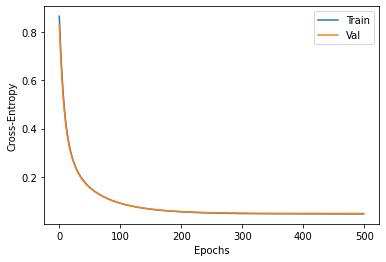

In [ ]:
model3 = build_model3()

history3 = model3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=500, batch_size=500).history

plt.plot(history3['loss'], label='Train')
plt.plot(history3['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

In [ ]:
# Test the model after training
test_results = model3.evaluate(X_test, y_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')

6168/6168 [==============================] - 0s 16us/step
Test results - Loss: 0.04840187181570071 - Accuracy: 0.9901102185249329%


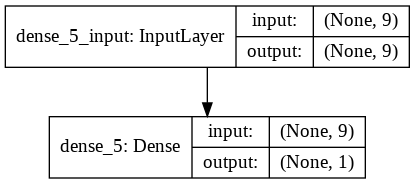

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model3, show_shapes=True, show_layer_names=True)


# OTTIMIZZAZIONE PERCEPTRON

## Early Stopping

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

Train on 11513 samples, validate on 2879 samples
Epoch 1/100
11513/11513 [==============================] - 0s 13us/step - loss: 0.6059 - accuracy: 0.7895 - val_loss: 0.5008 - val_accuracy: 0.9045
Epoch 2/100
11513/11513 [==============================] - 0s 4us/step - loss: 0.4485 - accuracy: 0.8895 - val_loss: 0.3951 - val_accuracy: 0.8993
Epoch 3/100
11513/11513 [==============================] - 0s 3us/step - loss: 0.3696 - accuracy: 0.9196 - val_loss: 0.3358 - val_accuracy: 0.9302
Epoch 4/100
11513/11513 [==============================] - 0s 4us/step - loss: 0.3215 - accuracy: 0.9407 - val_loss: 0.2964 - val_accuracy: 0.9545
Epoch 5/100
11513/11513 [==============================] - 0s 4us/step - loss: 0.2878 - accuracy: 0.9542 - val_loss: 0.2672 - val_accuracy: 0.9635
Epoch 6/100
11513/11513 [==============================] - 0s 3us/step - loss: 0.2623 - accuracy: 0.9631 - val_loss: 0.2445 - val_accuracy: 0.9677
Epoch 7/100
11513/11513 [==============================] - 0s 4us/st

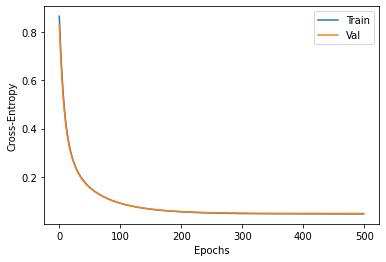

In [ ]:
es = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.05)
mc = ModelCheckpoint("/content/drive/Shared drives/DM2/files/bestmodel.h", monitor='val_loss', save_best_only=True)

model_opt = build_model()
history_opt = model_opt.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, 
                      batch_size=500, callbacks=[es,mc]).history

plt.plot(history3['loss'], label='Train')
plt.plot(history3['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

In [ ]:
test_loss_4, test_acc_4 = model_opt.evaluate(X_test, y_test)

print('Loss %f, Accuracy %f' % (test_loss_4, test_acc_4))

6168/6168 [==============================] - 0s 20us/step
Loss 0.081360, Accuracy 0.987516


## L2 Regularization

l'aggiunta del regolarizzatore l2 con valore 0.001 non ha portato a sostanziali modifiche nella rete neurale. aumentandone il valore a 0.1 la convergenza è stata più lenta ma comunque raggiunta

In [ ]:
from keras.regularizers import l2
n_feature = X_train.shape[1]


def build_L2_model():
    # define the model
    model = Sequential()
    model.add(Dense(5, input_dim=n_feature, activation='sigmoid', kernel_regularizer=l2(0.00001)))
    model.add(Dense(1, activation='sigmoid'))

    #compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

Train on 11513 samples, validate on 2879 samples
Epoch 1/500
11513/11513 [==============================] - 0s 11us/step - loss: 0.7991 - accuracy: 0.3964 - val_loss: 0.7713 - val_accuracy: 0.4179
Epoch 2/500
11513/11513 [==============================] - 0s 4us/step - loss: 0.7490 - accuracy: 0.4551 - val_loss: 0.7221 - val_accuracy: 0.5043
Epoch 3/500
11513/11513 [==============================] - 0s 3us/step - loss: 0.7024 - accuracy: 0.5431 - val_loss: 0.6769 - val_accuracy: 0.5856
Epoch 4/500
11513/11513 [==============================] - 0s 4us/step - loss: 0.6592 - accuracy: 0.6130 - val_loss: 0.6350 - val_accuracy: 0.6450
Epoch 5/500
11513/11513 [==============================] - 0s 4us/step - loss: 0.6198 - accuracy: 0.6905 - val_loss: 0.5970 - val_accuracy: 0.7315
Epoch 6/500
11513/11513 [==============================] - 0s 4us/step - loss: 0.5838 - accuracy: 0.7731 - val_loss: 0.5622 - val_accuracy: 0.8229
Epoch 7/500
11513/11513 [==============================] - 0s 4us/st

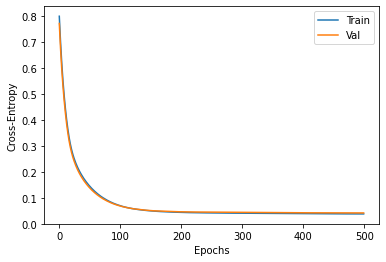

In [ ]:
mc = ModelCheckpoint('/content/drive/Shared drives/DM2/files/best_model_L2.h5', monitor='val_loss', save_best_only=True, period=100)

L2_model = build_L2_model()
h_L2 = L2_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, 
                    batch_size=500).history

plt.plot(h_L2['loss'], label='Train')
plt.plot(h_L2['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

aggiungendo una regolarizzazione dropout pari a 0.4 nello strato intermedio si è riscontrato un underfit del modello, sicuramente a causa dei pochi nodi presenti nello strato intermedio che ulteriormente eliminati durante le epoche. Ciò indica che il modello è in grado di apprendere ulteriormente con miglioramenti e che il processo di formazione è stato interrotto prematuramente. anche aumentando il numero di epoche da 500 a mille non si è riscontrata nessuna differenza.

anche con un dropout pari a 0.2 il modello è in underfit ma in scala minore.

In [ ]:
from keras.layers import Dropout
n_feature = X_train.shape[1]

def build_DROPOUT_model():
    # define the model
    model = Sequential()
    model.add(Dense(5, input_dim=n_feature, activation='sigmoid', kernel_regularizer=l2(0.00001)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    #compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model


Train on 11513 samples, validate on 2879 samples
Epoch 1/500
11513/11513 [==============================] - 0s 15us/step - loss: 0.8688 - accuracy: 0.3148 - val_loss: 0.8361 - val_accuracy: 0.3265
Epoch 2/500
11513/11513 [==============================] - 0s 4us/step - loss: 0.8189 - accuracy: 0.3665 - val_loss: 0.7870 - val_accuracy: 0.3567
Epoch 3/500
11513/11513 [==============================] - 0s 5us/step - loss: 0.7714 - accuracy: 0.4187 - val_loss: 0.7413 - val_accuracy: 0.4359
Epoch 4/500
11513/11513 [==============================] - 0s 4us/step - loss: 0.7289 - accuracy: 0.4926 - val_loss: 0.6997 - val_accuracy: 0.5564
Epoch 5/500
11513/11513 [==============================] - 0s 4us/step - loss: 0.6894 - accuracy: 0.5648 - val_loss: 0.6614 - val_accuracy: 0.6245
Epoch 6/500
11513/11513 [==============================] - 0s 4us/step - loss: 0.6534 - accuracy: 0.6243 - val_loss: 0.6262 - val_accuracy: 0.7197
Epoch 7/500
11513/11513 [==============================] - 0s 4us/st

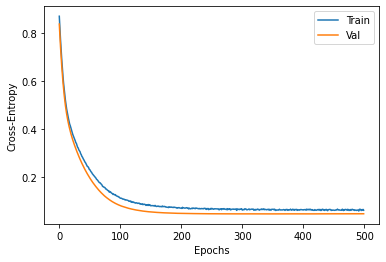

In [ ]:
mc = ModelCheckpoint('/content/drive/Shared drives/DM2/files/best_model_DROPOUT.h5', monitor='val_loss', save_best_only=True)

DROPOUT_model = build_DROPOUT_model()
h_DROPOUT = DROPOUT_model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                              epochs=500, batch_size=500).history

plt.plot(h_DROPOUT['loss'], label='Train')
plt.plot(h_DROPOUT['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

In [ ]:
# laod best models and test them
#from keras.models import load_model

#best_NOREG_model = load_model("/content/drive/Shared drives/DM2/files/bestmodel.h")
#best_L2_model = load_model('/content/drive/Shared drives/DM2/files/best_model_L2.h5')
#best_DROPOUT_model = load_model('/content/drive/Shared drives/DM2/files/best_model_DROPOUT.h5')

#loss_NOREG, acc_NOREG = best_NOREG_model.evaluate(X_test, y_test)
#loss_L2, acc_L2 = best_L2_model.evaluate(X_test, y_test)
#loss_DROPOUT, acc_DROPOUT = best_DROPOUT_model.evaluate(X_test, y_test)

In [ ]:
#print('Loss %f, Accuracy %f' % (loss_NOREG, acc_NOREG))
#print('Loss %f, Accuracy %f' % (loss_L2, acc_L2))
#print('Loss %f, Accuracy %f' % (loss_DROPOUT, acc_DROPOUT))